# Credit Card Fraud Detection

## Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
# for tensorflow version 2.0.0 and higher run the code below
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
import sklearn
import time
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## Loading Dataset

In [2]:
# Import and store dataset
credit_card_data = pd.read_csv('/tmp/creditcard.csv')
credit_card_data.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,-0.915427,-1.040458,-0.031513,-0.188093,-0.084316,0.041333,-0.302620,-0.660377,0.167430,-0.256117,0.382948,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


## Data Prep

In [0]:
# Shuffle and randomize data
shuffled_data = credit_card_data.sample(frac=1)

# Change Class column into Class_0 ([1 0] for legit data) and Class_1 ([0 1] for fraudulent data)
one_hot_data = pd.get_dummies(shuffled_data, columns=['Class'])

# Change all values into numbers between 0 and 1
normalized_data = (one_hot_data - one_hot_data.min()) / (one_hot_data.max() - one_hot_data.min())

# Store just columns V1 through V28 in df_X and columns Class_0 and Class_1 in df_y
df_X = normalized_data.drop(['Class_0', 'Class_1'], axis=1)
df_y = normalized_data[['Class_0', 'Class_1']]

# Convert both data_frames into np arrays of float32
ar_X, ar_y = np.asarray(df_X.values, dtype='float32'), np.asarray(df_y.values, dtype='float32')

# Allocate first 80% of data into training data and remaining 20% into testing data
train_size = int(0.8 * len(ar_X))
(raw_X_train, raw_y_train) = (ar_X[:train_size], ar_y[:train_size])
(raw_X_test, raw_y_test) = (ar_X[train_size:], ar_y[train_size:])

In [4]:
# Gets a percent of fraud vs legit transactions (0.0017% of transactions are fraudulent)
count_legit, count_fraud = np.unique(credit_card_data['Class'], return_counts=True)[1]
fraud_ratio = float(count_fraud / (count_legit + count_fraud))
print('Percent of fraudulent transactions: ', fraud_ratio)

Percent of fraudulent transactions:  0.001727485630620034


In [0]:
# Applies a logit weighting of 578 (1/0.0017) to fraudulent transactions to cause model to pay more attention to them
weighting = 1 / fraud_ratio
raw_y_train[:, 1] = raw_y_train[:, 1] * weighting

In [0]:
def prepare_batches(data, labels, batch_size):
    assert len(data) == len(labels)
    
    all_batches = list()
    for i in range(0, len(data)):
        all_batches.append((data[i], labels[i]))
    random.shuffle(all_batches)
        
    batches = list()
    while len(all_batches) >= batch_size:
        
        data_batch = list()
        labels_batch = list()
        for j in range(0, batch_size):
            data, labels = all_batches.pop()
            data_batch.append(data)
            labels_batch.append(labels)
            
        batches.append((np.array(data_batch), np.array(labels_batch)))
    
    return batches

## Neural Networks Prep

In [0]:
# 30 cells for the input
input_dimensions = ar_X.shape[1]

# 2 cells for the output
output_dimensions = ar_y.shape[1]

# 100 cells for the 1st layer
num_layer_1_cells = 100

# 150 cells for the second layer
num_layer_2_cells = 150

In [0]:
# reset tensorflow graph
tf.reset_default_graph()

# We will use these as inputs to the model when it comes time to train it (assign values at run time)
X_train_node = tf.placeholder(tf.float32, [None, input_dimensions], name='X_train')
y_train_node = tf.placeholder(tf.float32, [None, output_dimensions], name='y_train')
# learning_rate_ = tf.placeholder(tf.float32, None, name="learning_rate")

# We will use these as inputs to the model once it comes time to test it
X_test_node = tf.constant(raw_X_test, name='X_test')
y_test_node = tf.constant(raw_y_test, name='y_test')

# First layer takes in input and passes output to 2nd layer
weight_1_node = tf.Variable(tf.zeros([input_dimensions, num_layer_1_cells]), name='weight_1')
biases_1_node = tf.Variable(tf.zeros([num_layer_1_cells]), name='biases_1')

# Second layer takes in input from 1st layer and passes output to 3rd layer
weight_2_node = tf.Variable(tf.zeros([num_layer_1_cells, num_layer_2_cells]), name='weight_2')
biases_2_node = tf.Variable(tf.zeros([num_layer_2_cells]), name='biases_2')

# Third layer takes in input from 2nd layer and outputs [1 0] or [0 1] depending on fraud vs legit
weight_3_node = tf.Variable(tf.zeros([num_layer_2_cells, output_dimensions]), name='weight_3')
biases_3_node = tf.Variable(tf.zeros([output_dimensions]), name='biases_3')

In [0]:
#Function to run an input tensor through the 3 layers and output a tensor that will give us a fraud/legit result
# Each layer uses a different function to fit lines through the data and predict whether a given input tensor will \
#   result in a fraudulent or legitimate transaction

def network(input_tensor):
    
    # Sigmoid fits modified data well
    layer1 = tf.nn.sigmoid(tf.matmul(input_tensor, weight_1_node) + biases_1_node)
    
    # Dropout prevents model from becoming lazy and over confident
    layer2 = tf.nn.dropout(tf.nn.sigmoid(tf.matmul(layer1, weight_2_node) + biases_2_node), 0.85)
    
    # Softmax works very well with one hot encoding which is how results are outputted
    layer3 = tf.nn.softmax(tf.matmul(layer2, weight_3_node) + biases_3_node)
    return layer3

In [0]:
#Hyperparameters

epochs = 20
batch_size = 5000
learning_rate = 0.001

In [17]:
# Used to predict what results will be given training or testing input data
# Remember, X_train_node is just a placeholder for now. We will enter values at run time
y_train_prediction = network(X_train_node)
y_test_prediction = network(X_test_node)

# Cross entropy loss function measures differences between actual output and predicted output
cross_entropy = tf.losses.softmax_cross_entropy(y_train_node, y_train_prediction)

# Adam optimizer function will try to minimize loss (cross_entropy) but changing the 3 layers' variable values at a
#   learning rate of 0.005
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

# Function to calculate the accuracy of the actual result vs the predicted result
def calculate_accuracy(actual, predicted):
    actual = np.argmax(actual, 1)
    predicted = np.argmax(predicted, 1)
    return (100 * np.sum(np.equal(predicted, actual)) / predicted.shape[0])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Training

In [19]:
info = {'loss':[], 'val_loss':[], 'acc':[], 'val_acc':[]}

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(epochs):
        start_time = time.time()
        batches = prepare_batches(raw_X_train, raw_y_train, batch_size)
        
        epoch_losses = []
        epoch_accuracy = []
        
        while batches:

            data_inputs, data_labels = batches.pop()
        
            _, batch_loss = session.run([optimizer, cross_entropy],
                                             feed_dict={X_train_node: raw_X_train,
                                                        y_train_node: raw_y_train})
        
            epoch_y_test, epoch_y_test_prediction = y_test_node.eval(),y_test_prediction.eval()
            batch_acc = calculate_accuracy(epoch_y_test, epoch_y_test_prediction)

            epoch_losses.append(batch_loss)
            epoch_accuracy.append(batch_acc)


        train_loss = np.mean(epoch_losses)
        info['loss'].append(train_loss)

        train_accuracy = np.mean(epoch_accuracy)
        info['acc'].append(train_accuracy)
        
        val_loss = session.run(cross_entropy, feed_dict={X_train_node: raw_X_test, 
                                                              y_train_node: raw_y_test})
        info['val_loss'].append(val_loss)

        epoch_y_test, epoch_y_test_prediction = y_test_node.eval(), y_test_prediction.eval()
        val_accuracy = calculate_accuracy(epoch_y_test, epoch_y_test_prediction)
        info['val_acc'].append(val_accuracy)

        print("Epoch: " + str(epoch + 1) + "/" + str(epochs) + ":\n"
              + "      - Training loss: " + str(train_loss) + " (acc: " + str(train_accuracy) + ")\n"
              + "      - Validation loss: " + str(val_loss) + " (acc: " + str(val_accuracy) + ")")
    
    final_y_test, final_y_test_prediction = y_test_node.eval(), y_test_prediction.eval()
    final_val_accuracy = calculate_accuracy(final_y_test, final_y_test_prediction)

Epoch: 1/20:
      - Training loss: 1.36633 (acc: 99.71349320599698)
      - Validation loss: 0.6656657 (acc: 99.29953302201467)
Epoch: 2/20:
      - Training loss: 1.3395617 (acc: 94.60478525644778)
      - Validation loss: 0.6414866 (acc: 91.49081844036375)
Epoch: 3/20:
      - Training loss: 1.1791612 (acc: 95.65289140128506)
      - Validation loss: 0.5095131 (acc: 98.24444366419718)
Epoch: 4/20:
      - Training loss: 1.0086645 (acc: 98.90585926680164)
      - Validation loss: 0.43379763 (acc: 99.15382184614305)
Epoch: 5/20:
      - Training loss: 0.9230738 (acc: 99.41060121952647)
      - Validation loss: 0.39563182 (acc: 99.42593307819249)
Epoch: 6/20:
      - Training loss: 0.8805494 (acc: 99.53430942265604)
      - Validation loss: 0.37116212 (acc: 99.54004424001967)
Epoch: 7/20:
      - Training loss: 0.8546538 (acc: 99.5493291824179)
      - Validation loss: 0.35778314 (acc: 99.59446648642955)
Epoch: 8/20:
      - Training loss: 0.83988416 (acc: 99.5492901700549)
      - Val

## Model Analysis

In [20]:
final_fraud_y_test = final_y_test[final_y_test[:, 1] == 1]
final_fraud_y_test_prediction = final_y_test_prediction[final_y_test[:, 1] == 1]
final_fraud_accuracy = calculate_accuracy(final_fraud_y_test, final_fraud_y_test_prediction)
print('Final fraud specific accuracy: {0:.2f}%'.format(final_fraud_accuracy))

Final fraud specific accuracy: 88.99%


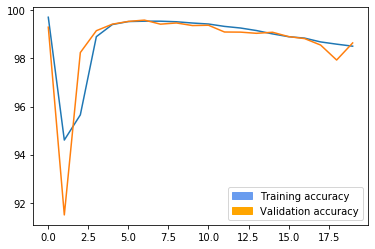

In [21]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(info['acc'], label='Training acc')
ax1.plot(info['val_acc'], label='Validation acc')
blue_patch = mpatches.Patch(color='#699cef', label='Training accuracy')
orange_patch = mpatches.Patch(color='orange', label='Validation accuracy')
ax1.legend(handles=[blue_patch, orange_patch])
plt.show()

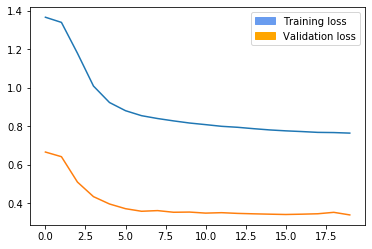

In [22]:
fig1 = plt.figure()
ax2 = fig1.add_subplot(111)
ax2.plot(info['loss'], label='Training loss')
ax2.plot(info['val_loss'], label='Validation loss')
blue_patch = mpatches.Patch(color='#699cef', label='Training loss')
orange_patch = mpatches.Patch(color='orange', label='Validation loss')
ax2.legend(handles=[blue_patch, orange_patch])
plt.show()

In [0]:
 #metrics
  y_p = tf.argmax(pred, 1)
  val_accuracy, y_pred = sess.run([accuracy, y_p], feed_dict={x:test_arrays, y:test_label})

  print "validation accuracy:", val_accuracy
  y_true = np.argmax(test_label,1)
  print "Precision", sk.metrics.precision_score(y_true, y_pred)
  print "Recall", sk.metrics.recall_score(y_true, y_pred)
  print "f1_score", sk.metrics.f1_score(y_true, y_pred)
  print "confusion_matrix"
  print sk.metrics.confusion_matrix(y_true, y_pred)
  fpr, tpr, tresholds = sk.metrics.roc_curve(y_true, y_pred)

In [0]:
session.close()